In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
import cv2 
import os 
import matplotlib.pyplot as plt 
import numpy as np
import random

import certifi

os.environ['SSL_CERT_FILE'] = certifi.where()

2024-07-08 21:15:59.230637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow.keras.backend as K
K.clear_session()

In [3]:
img_array = cv2.imread('data/train/0/Training_3908.jpg')
img_array.shape

(48, 48, 3)

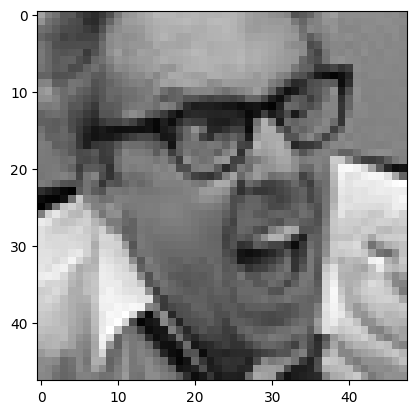

In [4]:
plt.imshow(img_array)

In [5]:
datadirectory = "data/train/"
classes = ["0" , '1' , '2' , '3' , '4' , '5' , '6']

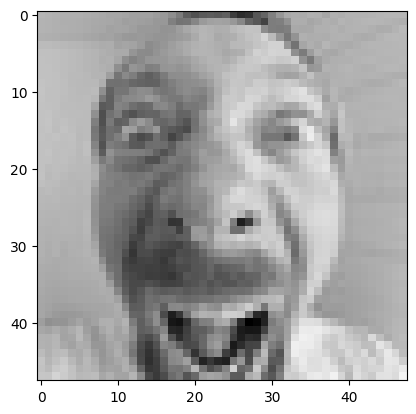

In [6]:
for category in classes:
    path = os.path.join(datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break 
    break

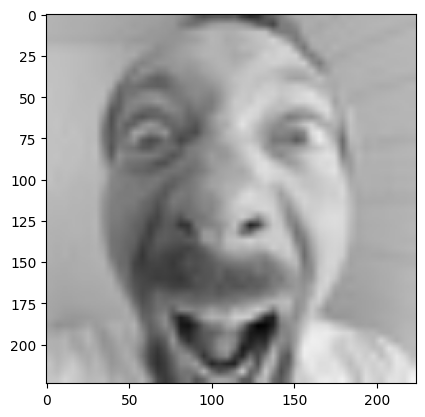

In [7]:
# Change the size of the image 
img_size = 224 
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
new_array.shape

(224, 224, 3)

# Read all images and convert them into arrays

In [9]:
training_data = [] # data array 

def create_training_data():
    for category in classes:
        path = os.path.join(datadirectory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

In [10]:
create_training_data()
print(len(training_data))

28709


# Deep learning model for training - Transfer learning

In [11]:
import os
import certifi
import requests
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import random

# Step 1: Ensure certifi is installed and up-to-date
os.system("pip install --upgrade certifi")

# Step 2: Set SSL certificate environment variable
os.environ['SSL_CERT_FILE'] = certifi.where()

# Step 3: Download the weights file using requests
url = "https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
response = requests.get(url, stream=True)
weights_path = "mobilenet_v2_weights_no_top.h5"
with open(weights_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

print("Download complete!")


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


Download complete!


In [12]:
random.shuffle(training_data)

x_data = []
y_data = []

for features, label in training_data:
    x_data.append(features)
    y_data.append(label)

x_data = np.array(x_data).reshape(-1, img_size, img_size, 3)
x_data = x_data / 255.0
Y = np.array(y_data)

In [13]:
# Step 5: Load the pre-trained MobileNetV2 model without the top layers
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights=weights_path, input_shape=(224, 224, 3))

# Step 6: Freeze the base model
base_model.trainable = False

In [14]:
# Step 7: Get the output of the base model and add new layers
base_output = base_model.output
x = layers.GlobalAveragePooling2D()(base_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
final_output = layers.Dense(len(classes), activation='softmax')(x)

In [15]:
# Step 8: Create the new model
new_model = Model(inputs=base_model.input, outputs=final_output)

In [16]:
# Step 10: Compile the model
new_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [17]:
new_model.fit(x_data, Y, epochs=1, batch_size=16)

: 